# Gérémy Michaud

<h1 style="text-align:center">Travail pratique numérique en thermodynamique statistique</h1>
<h2 style="text-align:center">PARTIE 2 : Modèle de Drude</h2>

Veuillez indiquer le nom des membres de votre équipe dans la cellule suivante.

- Pierre-Olivier Desrosiers<br>
- Nicolas Dorval<br>
- Gérémy Michaud<br>
- Félix-Antoine Dupuis

# Introduction # 
Cette deuxième partie du travail implémente une simulation 2D du modèle de Drude pour décrire le mouvement des électrons libres et indépendants dans les métaux. Des sphères dures sont encore utilisées pour représenter les particules, mais maintenant de deux types différents afin de différencier les coeurs ioniques immobiles des électrons sur leurs trajectoires balistiques. Les collisions entre les deux doivent donc être inélastiques. Les questions sur cette simulation, d'abord de cinétique puis de dynamique des électrons en présence d'une force externe appliquée au cristal, vérifieront quelques résultats analytiques du modèle de Drude obtenus en classe et/ou dans le manuel de cours Ashcroft/Mermin.

- **La remise du présent _Jupyter Notebook_ ET celui de la 1<sup>re</sup> partie, ainsi que tout autre fichier de code produit, se fait sur Gradescope en n'oubliant pas d'y indiquer tous les membres de votre équipe.**

# 2<sup>e</sup> partie - Modèle de Drude #

Faites une copie du script `TDS-2Dsimulation_HXX.py` et modifiez-le pour obtenir une simulation cinétique d'un gaz d'électrons libres dans la matière cristalline selon le modèle de Drude. Spécifiquement selon les pp.4-6 du manuel Ashcroft/Mermin,
1. ajoutez un deuxième type de sphères fixes réparties périodiquement dans la boîte d'animation: celles-ci représenteront les coeurs ioniques,
2. éliminez les collisions entre les sphères mobiles qui représentent maintenant les électrons de conduction indépendants et libres,
3. en faisant appel à la température du gaz, ajoutez des collisions inélastiques entre les électrons libres et les coeurs ioniques fixes. La quantité de mouvement $\vec{p}$ n'est alors PAS conservée et il faut appliquer les hypothèses spécifiques du modèle de Drude à la sortie de chaque collision, notamment: 
- la direction de $\vec{p}$ doit être aléatoire,
- la norme $||\vec{p}||$ est déterminée par la distribution de Maxwell-Boltzmann.

### Votre simulation ###

VII. _(25 points)_ &mdash; Écrivez un appel de votre nouveau script pour l'exécuter avec la cellule suivante:

In [1]:
from GM_TDS_Part2_2Dsimulation_H24 import DrudeModelSimulator
from vpython import *
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from IPython.display import display, Math
import seaborn as sns
palette = sns.color_palette("colorblind")

iterations = 1000
dt = 1E-7
pavg_list, pmag_electron = DrudeModelSimulator(iterations=iterations, dt=dt)

--- 35.105 seconds ---


### Question statistique ###

VIII. _(5 points)_ &mdash; Vérifiez numériquement et graphiquement que l'amortissement de la quantité de mouvement moyenne des électrons suit l'équation exponentielle dérivée analytiquement en classe, soit $\langle p(t)\rangle =\langle p(t_0)\rangle \,e^{-t/\tau}$, et comparez-y le comportement d'un seul électron.

<IPython.core.display.Math object>

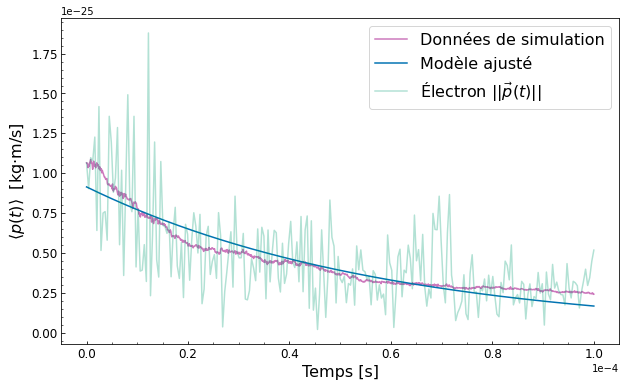

In [2]:
def pt_mean(t, p0, tau):
    return p0 * np.exp(-t / tau)

time_iter = np.linspace(0, iterations * dt, iterations)
t = np.linspace(0, iterations, iterations)
params, _ = curve_fit(pt_mean, t, pavg_list, p0=[pavg_list[0], 1])

predicted_values = pt_mean(t, *params)

residuals = pavg_list - predicted_values

# Calculer la somme des carrés des résidus et la somme totale des carrés
ssr = np.sum(residuals**2)
sst = np.sum((pavg_list - np.mean(pavg_list))**2)
# Calculer le coefficient de détermination R^2
r_squared = 1 - (ssr / sst)

display(Math(f'R^2 \\approx {r_squared:.2f}'))

plt.figure(figsize=(10, 6))
plt.plot(time_iter, pavg_list, color=palette[4], label="Données de simulation")
plt.plot(time_iter, predicted_values, color=palette[0], label=f"Modèle ajusté")
time_it = np.linspace(0, iterations * dt, len(pmag_electron))
plt.plot(time_it, pmag_electron, color=palette[2], alpha=0.3, label="Électron $||\\vec{{p}}(t)||$")
plt.legend(fontsize=16)
plt.minorticks_on()
plt.tick_params(which="both", axis="both", direction="in", labelsize=12)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlabel("Temps [s]", fontsize=16)
plt.ylabel(f"$\\left\\langle p(t) \\right\\rangle\;$ [kg$\\cdot$m/s]", fontsize=16)
plt.show()

Nous observons que la moyenne de la quantité de mouvement totale de tous les électrons suit un amortissement exponentiel au fil du temps (pour un nombre d'itérations suffisamment élevé, soit >5000). En effet, étant donné que les collisions sont inélastiques, il y a une diminution de la quantité de mouvement au fil du temps.

En ce qui concerne le comportement d'un seul électron, la norme de sa quantité de mouvement suit globalement la même tendance au fil du temps, mais avec beaucoup plus de fluctuations. Étant donné que les vitesses après les collisions sont distribuées de manière aléatoire selon la distribution des vitesses de Boltzmann, il est possible d'observer certaines augmentations de la quantité de mouvement de l'électron. Cependant, celui-ci subit malgré tout un amortissement global en raison de la diminution de la température et, par extension, de l'énergie totale du système.

### Dynamique sous l'effet d'une force externe ###

IX. _(10 points)_ &mdash; Pour passer de la cinétique à la dynamique des électrons libres, modifiez votre code de simulation en ajoutant une fonction qui applique un champ électrique uniforme. Celui-ci devra être de module ajustable et perpendiculaire à deux des côtés de la boîte. À chaque pas de temps $\mathrm{d}t$ sans collision, les électrons devront donc accélérer d'un incrément $\mathrm{d}p_x$ dicté par la force de Coulomb à leur position.

Copiez le code de votre fonction dans la cellule qui suit en n'oubliant pas d'inclure votre fichier Python (`.py`) modifié avec la simulation complète lors de la remise.

À partir de la force de Coulomb et de la deuxième loi de Newton, nous trouvons :
\begin{gather*}
F = q \cdot E \qquad \text{et} \qquad F = m\cdot a\;, \\
\Rightarrow\;m\cdot a = q \cdot E\;,
\end{gather*}
où $q$ est la charge élémentaire et $E$ est l'intensité du champ électrique.


En multipliant les deux côtés de l'équation par un intervalle de temps $\mathrm{d} t$, nous obtenons un incrément de la quantité de mouvement :
\begin{gather*}
m\cdot a \cdot \mathrm{d}t = q \cdot E \cdot \mathrm{d}t\;, \\
\mathrm{d}p = q \cdot E \cdot \mathrm{d}t\;.
\end{gather*}

En appliquant un champ électrique uniforme dans la direction $\pm x$, l'incrément en $x$ de la quantité de mouvement est donné par ::
\begin{gather*}
\mathrm{d}p_x = q\cdot E_x \cdot \mathrm{d} t\;.
\end{gather*}

Ici, un champ $E_{+x}$ est dirigé vers la droite et un champ $E_{-x}$ est dirigé vers la gauche.

L'ajout dans la simulation du fichier `.py` pour ce numéro a été effectué à la fin de la boucle itérant sur les indices des particules participant à une collision. Voici l'extrait de code en question :
```python
for index, _ in enumerate(p):
    if index != i:
        p[index].x += q * champ * dt
```
Cette modification garantit que la fonction de champ est uniforme et perpendiculaire à deux côtés, tandis que seules les particules libres, n'ayant pas subi de collision, subissent une modification de leur quantité de mouvement due au champ externe.

Le code ci-dessous présente un exemple de simulation pour un champ donné. Il est recommandé d'utiliser des valeurs de champ conservateur et des petits incréments de temps afin de prévenir tout problème potentiel dans la simulation. Voici les valeurs recommandées :

* Champ < 0.1 [V/m]
* Incrément de temps < $1 \times 10^{-8}$ [s]

L'utilisation de ces valeurs conseillées contribuera à assurer la stabilité et la précision de la simulation. 

In [10]:
champ = 0.05
itera = 1000
dtt = 1E-8

DrudeModelSimulator(iterations=itera, champ=champ, dt=dtt);

--- 46.818 seconds ---


### Question statistique ###

X. _(5 points)_ &mdash; Pour quelques différents modules de champ électrique, présentez graphiquement l'évolution de la position moyenne des électrons en fonction du temps pour ses deux composantes parallèle et perpendiculaire au champ.

# Médiagraphie #
- P. Drude, _Zur Elektronentheorie der Metalle; I Teil_, Annalen der Physik **306**(3), pp.566–613 (1900) https://doi.org/10.1002/andp.19003060312
- P. Drude, _Zur Elektronentheorie der Metalle; II Teil. Galvanomagnetische und Thermomagnetische Effecte_, Annalen der Physik **308**(11), pp.369–402 (1900) https://doi.org/10.1002/andp.19003081102
- P. Drude, _Zur Elektronentheorie der Metalle; Berichtigung_, Annalen der Physik **312**(3), pp.687–692 (1902) https://doi.org/10.1002/andp.19023120312
- H. A. Lorentz, _The Motion of Electrons in Metallic Bodies I_, Proc. of Koninklijke Akademie van Wetenschappen **7**, pp.438-453 (1905) https://dwc.knaw.nl/DL/publications/PU00013989.pdf
- H. A. Lorentz, _The Motion of Electrons in Metallic Bodies II_, Proc. of Koninklijke Akademie van Wetenschappen **7**, pp.585-593 (1905) https://dwc.knaw.nl/DL/publications/PU00014010.pdf
- H. A. Lorentz, _The Motion of Electrons in Metallic Bodies III_, Proc. of Koninklijke Akademie van Wetenschappen **7**, pp.684-691 (1905) https://dwc.knaw.nl/DL/publications/PU00014024.pdf
- La simulation utilise la librairie <a href="https://vpython.org">VPython</a> conçue pour faciliter la visualisation de physique en 3D, avec les instructions d’installation <a href="https://vpython.org/presentation2018/install.html">ici</a> et la documentation <a href="https://www.glowscript.org/docs/VPythonDocs/index.html">ici</a>. Le code adapte en 2D et commente en détail l’exemple <a href="https://www.glowscript.org/#/user/GlowScriptDemos/folder/Examples/program/HardSphereGas-VPython">HardSphereGas-VPython</a> du site interactif <a href="https://www.glowscript.org">GlowScript</a> pour programmer des animations avec VPython directement en ligne.